## Import Library

In [1]:
# Import library 
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
import seaborn as sns

Kode di atas adalah import library yang dibutuhkan.
`os` digunakan untuk navigasi folder dan membaca file.
`cv2` (OpenCV) digunakan untuk membaca dan memproses citra.
`matplotlib.pyplot` digunakan untuk visualisasi gambar dan grafik.
`numpy` digunakan untuk memanipulasi array dan data numerik.
`pandas` digunakan untuk memanipulasi data dalam bentuk tabel.
`train_test_split` dan `cross_val_predict` digunakan untuk membagi data dan validasi silang.
`accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `classification_report`, `confusion_matrix` dan `ConfusionMatrixDisplay` adalah matriks evaluasi model.
`graycomatrix`dan `graycoprops` digunakan untuk ekstraksi fitur tekstur menggunakan GLCM.
`entropy` digunakan untuk menghitung entropi fitur tekstur.
`RandomForestClassifier`, `SVC`dan `KNeighborsClassifier` digunakan sebagai algoritma klasifikasi yang digunakan dalam proyek.
`seaborn` digunakan untuk visualisasi heatmap dan grafik lainnya.

## Data Loading

_Data loading_ adalah proses pengambilan data dari sumber data yang ada agar data bisa diolah.

In [2]:
def resize_image(img_path, size):
    try:
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"Image at {img_path} could not be read.")
        resized_img = cv.resize(img, size)
        return resized_img
    except Exception as e:
        print(f"Error resizing image {img_path}: {e}")
        return None

Kode di atas adalah fungsi `resize_image(img_path, size)` yang digunakan untuk mengubah ukuran gambar. 

Pada blok `try`, gambar terlebih dahulu dibaca menggunakan `cv.imread()`. Jika gambar tidak bisa dibaca (`if img is None`), maka pesan _error_ akan dikeluarkan. Jika gambar berhasil dibaca, gambar akan di-_resize_ menggunakan `cv.resize()` 

Pada blok `except`, jika terjadi kesalahan saat membaca gambar, maka pesan _error_ akan ditampilkan.

Kode di bawah adalah fungsi `load_dataset(dir)` yang digunakan untuk membaca, menyimpan dan mengubah ukuran gambar.

Variabel `class_names` semua folder akan dibaca dan dianggap sebagai kelas dan `class_counter` digunakan untuk menghitung jumlah gambar dalam setiap kelas.

`for label, class_name in enumerate(class_names)` melakukan iterasi untuk setiap `class_name` yang ditemukan di dataset. `if os.path.isdir(class_dir):` digunakan untuk memastikan bahwa `class_dir` adalah folder _class_ bukan file. Setelahnya dilakukan iterasi terhadap semua file yang ada di class, jumlah gambar masing-masing di setiap class dibatasi menjadi 100. `img_path = os.path.join(class_dir, file_name)` digunakan untuk mengambil _path_ dari gambar dan kemudian di-_resize_. Jika proses membaca gambar berhasil, maka `class_counter[class_name]+=1` 

Setelah gambar dicetak dan dilabeli berdasarkan nama _class_, akan dicetak jumlah total gambar dan jumlah _class_ yang ditemukan. Visualisasi distribusi jumlah gambar per _class_ dilakukan dengan menggunakan barplot.

Loading dataset...
Dataset loaded with 200 images across 2 classes.


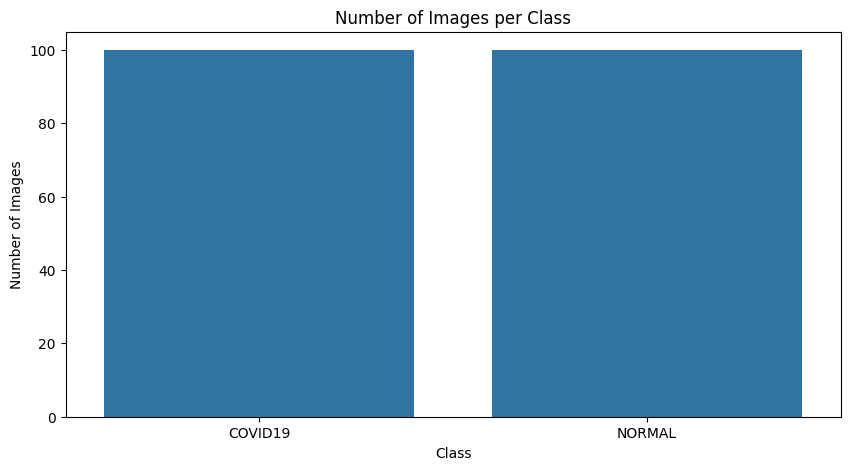

In [3]:
def load_dataset(dir):
    size = (250,250)
    images = []
    labels = []
    class_names = os.listdir(dir)
    class_counter = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if class_counter[class_name] >= 100:
                    break
                img_path = os.path.join(class_dir, file_name)
                img = resize_image(img_path, size)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                    class_counter[class_name]+=1
    return np.array(images), np.array(labels), class_names, class_counter


print("Loading dataset...")
images, labels, class_names, class_counter = load_dataset('Chest X_Ray Dataset')
print(f"Dataset loaded with {len(images)} images across {len(class_names)} classes.")
# Diagram Dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.savefig('dataset_distribution.png')
plt.show()

Kode di bawah adalah fungsi `show_sample_images(images, labels, class_names)` yang digunakan untuk menampilkan gambar sample dari tiap-tiap _class_. `for i, class_name in enumerate(class_names):`
akan melakukan iterasi untuk setiap `class`. `class_images = images[labels == class_name]` akan mengambil semua gambar yang memiliki label sama dengan `class`. Gambar yang ditampilkan adalah gambar ke-11 (indeks ke-10) dari masing-masing _class_ dengan warna RGB. 

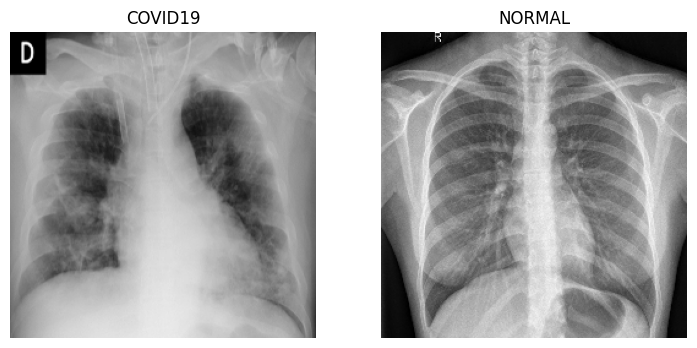

In [4]:
# Menampilkan gambar sample dari setiap kelas
def show_sample_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name]
        if len(class_images) > 0:
            plt.subplot(3, 4, i + 1)
            plt.imshow(cv.cvtColor(class_images[10], cv.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
show_sample_images(images, labels, class_names)

Kode di bawah ini digunakan untuk mengonversi semua gambar menjadi _grayscale_. Gambar hasil _grayscale_ kemudian disimpan di dalam list `img_grey`. Gambar _greyscale_ kemudian ditampilkan masing-masing satu pada setiap kelas dengan menggunakan fungsi `show_sample_images`.

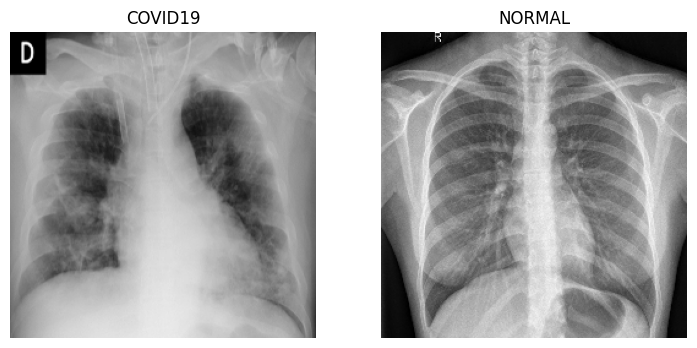

In [5]:
img_grey = []
for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_grey.append(gray)
img_grey = np.array(img_grey)

show_sample_images(img_grey, labels, class_names)

### **PreProcessing 1** **(MEDIAN, EKUALISASI)**

Kode di bawah digunakan untuk melakukan pendeteksian tepi menggunakan operator Prewitt. Untuk deteksi tepi operator Prewitt, digunakan dua buah kernel yaitu kernel `Px` dan kernel `Py`.

Fungsi `padding_baris(image)` digunakan untuk menambahkan _padding_ pada baris terakhir sebuah citra. _Padding_ ini diperlukan agar ketika melakukan proses konvolusi, ukuran citra asli dapat dipertahankan. _Padding_ diberikan dengan menambahkankan nilai 0 di setiap akhir baris _array_.`img_pad` adalah _array_ baru yang dibuat untuk menyimpan hasil _padding_. Ukuran `img_pad` sama dengan citra asal yang lebarnya ditambah 1. Kemudian isi dari citra di-_copy_ ke dalam `img_pad`. Karena _array_-nya memiliki lebar lebih 1 piksel daripada citra asli, kelebihan 1 piksel tersebut akan tetap bernilai 0.

Fungsi `padding_kolom(image)` digunakan untuk menambahkan _padding_ pada kolom terakhir sebuah citra. _Padding_ diberikan dengan menambahkan nilai 0 di setiap akhir kolom _array_.`img_pad` adalah _array_ baru yang dibuat untuk menyimpan hasil _padding_. Ukuran `img_pad` sama dengan citra asal yang tingginya ditambah 1. Kemudian isi dari citra di-_copy_ ke dalam `img_pad`. Karena _array_-nya memiliki tinggi lebih 1 piksel daripada citra asli, kelebihan 1 piksel tersebut akan tetap bernilai 0.

Fungsi `convo_edge(image, kernel, jenis)` digunakan untuk melakukan konvolusi pada deteksi tepi. Fungsi `convo_edge` menerima tiga parameter: `image`, `kernel` , dan `jenis`. Fungsi ini menghitung ukuran citra dan kernel, lalu menentukan ukuran _padding_ berdasarkan separuh ukuran kernel. _Padding_ ini diperlukan agar konvolusi bisa diterapkan di seluruh piksel, termasuk di tepi citra.
Jika jenis operator bukan "roberts", fungsi melakukan _padding_ nol (`mode='constant'`) di sekeliling citra. Namun jika jenisnya "roberts", fungsi menggunakan dua fungsi khusus (`padding_baris` dan `padding_kolom`) untuk memberi _padding_ secara manual.
Setelah citra dipersiapkan, fungsi menginisialisasi matriks `result` berukuran sama dengan citra asli. Lalu dilakukan proses konvolusi: untuk setiap piksel (i, j), diambil area lokal sesuai ukuran kernel, dikalikan elemen per elemen dengan kernel, dan hasilnya dijumlahkan untuk menjadi nilai baru piksel di `result[i, j]`.

Fungsi `deteksi_tepi(image, kernelX, kernelY, jenis)` digunakan untuk melakukan deteksi tepi menggunakan dua arah gradien (horizontal dan vertikal). Proses deteksi diawali dengan memanggil fungsi `convo_edge`, yang akan melakukan konvolusi antara citra input dengan masing-masing kernel (`kernelX` dan `kernelY`) untuk mendeteksi perubahan intensitas dalam arah horizontal dan vertikal. Hasil dari konvolusi tersebut adalah dua citra turunan pertama: `hasilX` (untuk arah X) dan `hasilY` (untuk arah Y).
Setelah mendapatkan kedua hasil tersebut, fungsi menghitung magnitudo gradien menggunakan rumus: `np.sqrt(hasilX**2 + hasilY**2)`.

Gambar kemudian diproses dengan menggunakan fungsi `deteksi_tepi` yang kemudian disimpan di _list_ `img_prewitt`. _Sample_ dari masing-masing class kemudian di tampilkan menggunakan `show_sample_images(img_prewitt, labels, class_names)`.

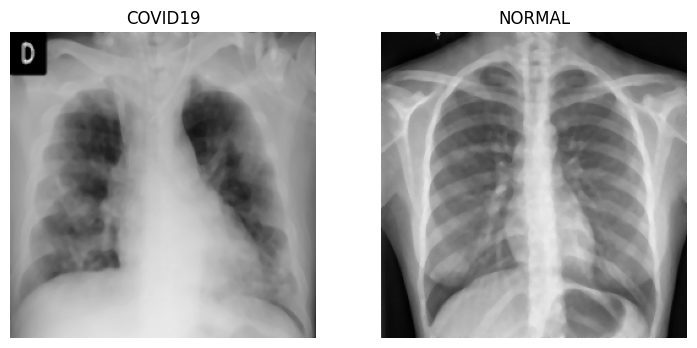

In [6]:
Px = np.array([[-1,0,1],
               [-1,0,1],
               [-1,0,1]])

Py = np.array([[1,1,1],
               [0,0,0],
               [-1,-1,-1]])

kernel_3x3 = np.full((3, 3), 1/9)

def median(img, kernel):
    height, width = img.shape
    hasil = img.copy().astype('int32')  
    
    for i in range(kernel.shape[0]//2, height - kernel.shape[0]//2):
        for j in range(kernel.shape[1]//2, width - kernel.shape[1]//2):
            temp = []
            for k in range(-kernel.shape[0]//2, kernel.shape[0]//2 + 1):
                for l in range(-kernel.shape[1]//2, kernel.shape[1]//2 + 1):
                    temp.append(int(img[i+k, j+l])) 
                    
            temp.sort() 
            mid = len(temp) // 2
            median_val = (temp[mid - 1] + temp[mid]) // 2
            hasil[i,j] = median_val
    
    return hasil.astype(img.dtype)

# Menerapkan konvolusi median
img_median = []
for img in img_grey:
    median_img = median(img, kernel_3x3)
    img_median.append(median_img)
img_median = np.array(img_median)
show_sample_images(img_median, labels, class_names)


Kode di bawah digunakan untuk menerapkan filter median pada gambar yang sebelumnya diproses menggunakan operator Prewitt. Kernel yang digunakan untuk filter median adalah kernel berukuran 3x3 yang elemennya berisi nilai 1/9.  

Fungsi `hitung_median(image)` digunakan untuk menghitung median (nilai intensitas piksel yang berada di tengah setelah diurutkan dari nilai terkecil ke nilai terbesar) dengan menggunakan `np.median`.

Fungsi `convo_statistik(image, kernel)` digunakan untuk melakukan proses _filtering_ median. Proses ini bekerja dengan cara yang mirip seperti konvolusi. Citra input diberikan padding sebanyak 1/2 kernel dan diisi oleh piksel tetangga. Iterasi dilakukan sebanyak baris dan kolom, kemudian nilai median dihitung menggunakan fungsi `hitung_median()` dan disimpan pada `result`.

Gambar kemudian diproses dengan menggunakan fungsi `convo_statistik` yang kemudian disimpan di _list_ `img_median`. _Sample_ dari masing-masing class kemudian di tampilkan menggunakan `show_sample_images(img_median, labels, class_names)`.

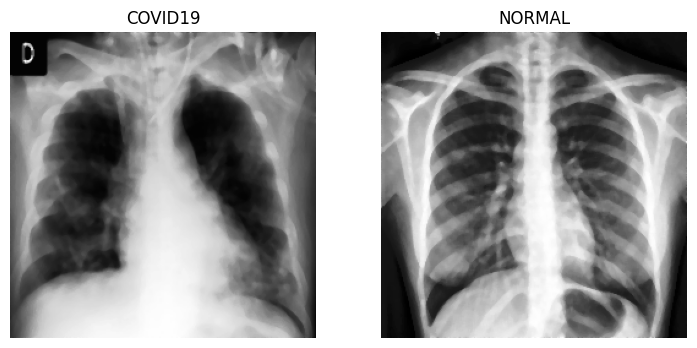

In [7]:
def equalization(image):
    hist = np.zeros(256).astype(int)
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            val = image[i, j]
            hist[val] += 1

    gldc = np.zeros(256).astype(int)
    for i in range(256):
        gldc[i] = np.sum(hist[0:i+1])

    target_value = gldc * (256-1) / (height*width)
    target_value = np.floor(target_value).astype(np.uint8)  # konversi ke uint8 di sini

    result = np.zeros(image.shape, dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            result[i, j] = target_value[image[i, j]]

    return result

# Proses ke semua gambar
img_equalization = []
for img in img_median:  
    equalization_img = equalization(img)
    img_equalization.append(equalization_img)
img_equalization = np.array(img_equalization)

# Tampilkan sample gambar
show_sample_images(img_equalization, labels, class_names)

### Feature Extraction

In [8]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Kode di atas adalah fungsi `glcm(image, derajat)` yang digunakan untuk menghasilkan matriks GLCM (_Gray Level Co-occurrence Matrix_). Parameter `derajat` digunakan untuk menentukan arah perhitungan hubungan antar piksel: 0 derajat (horizontal), 45 derajat (diagonal kanan atas), 90 derajat (vertikal), atau 135 derajat (diagonal kiri atas). Jika `derajat` bernilai 0, maka sudut arah piksel diset menjadi 0 radian yang mewakili arah horizontal. Jika bernilai 45, maka arah piksel diatur menjadi π/4 radian yang menunjuk ke arah diagonal kanan atas. Untuk derajat 90, arah piksel diatur menjadi π/2 radian, sedangkan untuk 135 derajat, sudutnya menjadi 3π/4 radian. Apabila nilai derajat yang diberikan tidak termasuk ke dalam empat nilai yang valid, maka program akan menampilkan pesan _error_.
Setelah menentukan arah, fungsi akan memanggil `graycomatrix()` dari pustaka `skimage.feature`. Fungsi ini menghitung GLCM dari citra image dengan jarak antar piksel sebesar 1 piksel dan arah sesuai dengan `angles`. Parameter tambahan seperti 256 menunjukkan jumlah level keabuan dalam gambar (0 hingga 255),` symmetric=True` agar matriks simetris, dan `normed=True` agar hasilnya dinormalisasi.

In [9]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Kode di atas adalah fungsi `correlation(mariks)` yang digunakan untuk menghitung fitur tekstur _correlation_ dari sebuah GLCM (_Gray Level Co-occurrence Matrix_). Fitur _correlation_ ini mengukur hubungan linear antara piksel dan tetangganya.
Fungsi ini mengembalikan _array_ dua dimensi, dan karena hanya satu arah (sudut) digunakan dalam pembuatan GLCM, maka nilai diakses menggunakan indeks `[0, 0]`, sehingga hasil akhirnya adalah sebuah angka (_float_) yang menyatakan nilai korelasi antara piksel dan tetangganya dalam tekstur citra tersebut.

In [10]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Kode di atas adalah fungsi `dissimilarity(matriks)` yang digunakan untuk menghitung nilai _dissimilarity_ dari sebuah GLCM (_Gray Level Co-occurrence Matrix_). Fitur _dissimilarity_ ini mengukur seberapa berbeda nilai intensitas antara piksel dan tetangganya, semakin besar nilainya, semakin kontras atau tidak mirip antar piksel yang bersebelahan. Fungsi ini mengembalikan _array_ dua dimensi, dan karena hanya satu arah (sudut) digunakan dalam pembuatan GLCM, maka nilai diakses menggunakan indeks `[0, 0]`.

In [11]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Kode di atas adalah fungsi `homogenity(matriks)` yang digunakan untuk menghitung nilai _homogeneity_ dari sebuah matriks GLCM (_Gray Level Co-occurrence Matrix_). Fitur _homogeneity_ mencerminkan tingkat keseragaman atau kemiripan antar nilai piksel dalam citra.

In [12]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Kode di atas adalah fungsi `contrast(matriks)` yang digunakan untuk menghitung nilai _contrast_ dari sebuah matriks GLCM (_Gray Level Co-occurrence Matrix_). Fitur ini mengukur perbedaan intensitas antara piksel dan tetangganya dalam seluruh gambar. Semakin besar nilai contrast, semakin tajam perbedaan antara area terang dan gelap.

In [13]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Kode di atas adalah fungsi `ASM(matriks)` yang digunakan untuk menghitung nilai ASM (_Angular Second Moment_) dari sebuah matriks GLCM (_Gray Level Co-occurrence Matrix_). Fitur ASM menggambarkan tingkat keteraturan atau homogenitas dalam suatu tekstur. Nilai ASM yang tinggi menunjukkan tekstur yang lebih teratur dan homogen, sedangkan nilai yang rendah menunjukkan tekstur yang lebih acak atau kompleks.

In [14]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Kode di atas adalah fungsi `energy(matriks)` digunakan untuk menghitung nilai _Energy_ dari sebuah matriks GLCM (_Gray Level Co-occurrence Matrix_). Nilai _energy_ mencerminkan tingkat keseragaman atau keteraturan dalam tekstur citra di mana semakin tinggi nilainya, semakin homogen atau teraturnya tekstur.

In [15]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode di atas adalah fungsi `entropyGlcm(matriks)` yang digunakan untuk menghitung nilai _entropy_ dari sebuah matriks GLCM (_Gray Level Co-occurrence Matrix_). Fitur _entropy_ mengukur kerandoman atau kekacauan dalam distribusi tekstur. Nilai _entropy_ yang tinggi menunjukkan tekstur yang lebih kompleks dan tidak beraturan, sedangkan nilai yang rendah menunjukkan tekstur yang lebih homogen dan teratur.

In [16]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(img_median)):
    D0 = glcm(img_median[i], 0)
    D45 = glcm(img_median[i], 45)
    D90 = glcm(img_median[i], 90)
    D135 = glcm(img_median[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas digunakan untuk menghitung GLCM (_Gray Level Co-occurrence Matrix_) dari setiap citra hasil _filtering_ median pada berbagai arah sudut, yaitu 0°, 45°, 90°, dan 135°.
Dibuat empat _list_ kosong, yaitu `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`, untuk menyimpan GLCM dari setiap citra sudut tertentu. Kemudian dilakukan perulangan `for` sebanyak jumlah citra dalam `img_median`. Di dalam setiap iterasi, fungsi `glcm()` dipanggil sebanyak empat kali untuk menghitung GLCM dari citra ke-i dengan parameter sudut 0°, 45°, 90°, dan 135°. Setiap hasil GLCM dari keempat arah tersebut kemudian dimasukkan ke dalam _list_ yang sesuai.

In [17]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode di atas digunakan untuk menyiapkan _list_ yang akan menyimpan hasil GLCM. Untuk masing-masing fitur dan sudut arah, dibuat _list_ kosong yang nantinya akan diisi dengan nilai hasil ekstraksi. Misalnya, `Kontras0` akan menyimpan nilai _contrast_ dari semua citra pada sudut 0°, `dissimilarity90` menyimpan nilai _dissimilarity_ pada sudut 90°, dan seterusnya.

In [18]:
for i in range(len(img_median)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode di atas digunakan untuk mengekstraksi fitur _correlation_ dari matriks GLCM.
Kode melakukan iterasi sebanyak jumlah gambar median (`img_median`). Untuk setiap gambar, diambil masing-masing matriks GLCM dari empat arah yang telah disimpan sebelumnya di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `correlation()` dipanggil untuk menghitung nilai fitur _correlation_. Nilai hasil perhitungan dari setiap arah kemudian disimpan ke dalam list yang sesuai, yaitu `correlation0`, `correlation45`, `correlation90`, dan `correlation135`.

In [19]:
for i in range(len(img_median)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di atas digunakan untuk mengekstraksi fitur _contrast_ dari matriks GLCM.
Kode melakukan iterasi sebanyak jumlah gambar median (`img_median`). Untuk setiap gambar, diambil masing-masing matriks GLCM dari empat arah yang telah disimpan sebelumnya di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `contrast()` dipanggil untuk menghitung nilai fitur _contrast_. Nilai hasil perhitungan dari setiap arah kemudian disimpan ke dalam list yang sesuai, yaitu `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`.

In [20]:
for i in range(len(img_median)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di atas digunakan untuk mengekstraksi fitur _dissimilarity_ dari matriks GLCM.
Kode melakukan iterasi sebanyak jumlah gambar median (`img_median`). Untuk setiap gambar, diambil masing-masing matriks GLCM dari empat arah yang telah disimpan sebelumnya di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `dissimilarity()` dipanggil untuk menghitung nilai fitur _dissimilarity_. Nilai hasil perhitungan dari setiap arah kemudian disimpan ke dalam list yang sesuai, yaitu `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`.

In [21]:
for i in range(len(img_median)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode di atas digunakan untuk mengekstraksi fitur _homogeneity_ dari matriks GLCM.
Kode melakukan iterasi sebanyak jumlah gambar median (`img_median`). Untuk setiap gambar, diambil masing-masing matriks GLCM dari empat arah yang telah disimpan sebelumnya di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `homogenity()` dipanggil untuk menghitung nilai fitur _homogeneity_. Nilai hasil perhitungan dari setiap arah kemudian disimpan ke dalam list yang sesuai, yaitu `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`.

In [22]:
for i in range(len(img_median)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode di atas digunakan untuk mengekstraksi fitur _entropy_ dari matriks GLCM.
Kode melakukan iterasi sebanyak jumlah gambar median (`img_median`). Untuk setiap gambar, diambil masing-masing matriks GLCM dari empat arah yang telah disimpan sebelumnya di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `entropyGlcm()` dipanggil untuk menghitung nilai fitur _entropy_. Nilai hasil perhitungan dari setiap arah kemudian disimpan ke dalam list yang sesuai, yaitu `entropy0`, `entropy45`, `entropy90`, dan `entropy135`.

In [23]:
for i in range(len(img_median)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di atas digunakan untuk mengekstraksi fitur ASM dari matriks GLCM.
Kode melakukan iterasi sebanyak jumlah gambar median (`img_median`). Untuk setiap gambar, diambil masing-masing matriks GLCM dari empat arah yang telah disimpan sebelumnya di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `ASM()` dipanggil untuk menghitung nilai fitur ASM. Nilai hasil perhitungan dari setiap arah kemudian disimpan ke dalam list yang sesuai, yaitu `ASM0`, `ASM45`, `ASM90`, dan `ASM135`.

In [24]:
for i in range(len(img_median)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di atas digunakan untuk mengekstraksi fitur _energy_ dari matriks GLCM.
Kode melakukan iterasi sebanyak jumlah gambar median (`img_median`). Untuk setiap gambar, diambil masing-masing matriks GLCM dari empat arah yang telah disimpan sebelumnya di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `energy()` dipanggil untuk menghitung nilai fitur _energy_. Nilai hasil perhitungan dari setiap arah kemudian disimpan ke dalam list yang sesuai, yaitu `energy0`, `energy45`, `energy90`, dan `energy135`.

### Write the extraction's results to CSV 

In [25]:
dataTable = {'Filename': [f'Image_{i+1}' for i in range(len(img_median))],
        'Class': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_pros3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_pros3.csv')
hasilEkstrak = hasilEkstrak.drop(columns=['Filename'])
x = hasilEkstrak.drop(columns=['Class'])
y = hasilEkstrak['Class']


Kode di atas digunakan untuk menyusun hasil ekstraksi fitur GLCM ke dalam bentuk tabel, menyimpannya ke file CSV, dan mempersiapkan data untuk _training_ model klasifikasi.
`dataTable` adalah _dictionary_ yang berisi data hasil ekstraksi fitur. Key `'Filename'` diisi dengan daftar nama gambar secara berurutan. Key `'Class'` berisi label kelas dari masing-masing gambar. Kemudian, nilai-nilai fitur GLCM yang sebelumnya dimasukkan ke dalam _dictionary_ ini.
Selanjutnya, _dictionary_ ini dikonversi menjadi objek `DataFrame` dengan bantuan `pandas` dan disimpan ke dalam file CSV bernama `'hasil_ekstraksi_pros3.csv'`. Setelah itu, file CSV yang telah dibuat dibaca kembali menjadi `DataFrame` bernama `hasilEkstrak`. Kolom `'Filename'` kemudian dihapus karena tidak diperlukan dalam proses klasifikasi.
Setelah itu, data dipisahkan menjadi dua variabel yang nantinya akan digunakan dalam _training_ dan _testing_ model klasifikasi, yaitu `x` yang berisi fitur numerik hasil ekstraksi (fitur input), dan `y` yang berisi label kelas untuk setiap gambar (target output). 

### Features Selection /////

Kode di bawah digunakan untuk menghitung dan menampilkan _correlation matrix_ dari fitur-fitur hasil ekstraksi GLCM dalam bentuk _heatmap_.
`x.corr()` menghitung korelasi antar fitur numerik pada `x`, yaitu data fitur hasil ekstraksi GLCM. Hasilnya adalah `correlation_matrix` yang berisi nilai antara -1 hingga 1. Nilai mendekati 1 menunjukkan korelasi positif kuat, mendekati -1 menunjukkan korelasi negatif kuat, dan mendekati 0 berarti tidak ada korelasi linear yang signifikan antara dua fitur.
Lalu, `plt.figure(figsize=(20, 16))` mengatur ukuran gambar. `sns.heatmap()` digunakan untuk memvisualisasikan matriks korelasi dalam bentuk _heatmap_. Argumen `annot=True` menampilkan nilai korelasi di setiap kotak, `fmt=".2f"` membatasi angka menjadi dua desimal, `cmap='coolwarm'` menentukan skema warna dari biru ke merah (dari negatif ke positif), dan `square=True` membuat setiap sel kotak dalam _heatmap_ berbentuk persegi.
Setelah itu, `plt.title()` menambahkan judul pada _heatmap_, dan `plt.savefig('correlation_matrix3.png')` menyimpan hasil visualisasi ke dalam file gambar bernama `correlation_matrix3.png`. Heatmap ditampilkan dengan menggunakan `plt.show()`.

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 20376.1211 - mae: 130.6683
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 20535.4727 - mae: 131.0592
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 20152.9746 - mae: 129.9791
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 20405.4043 - mae: 131.0512
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 20501.7480 - mae: 131.1365
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step


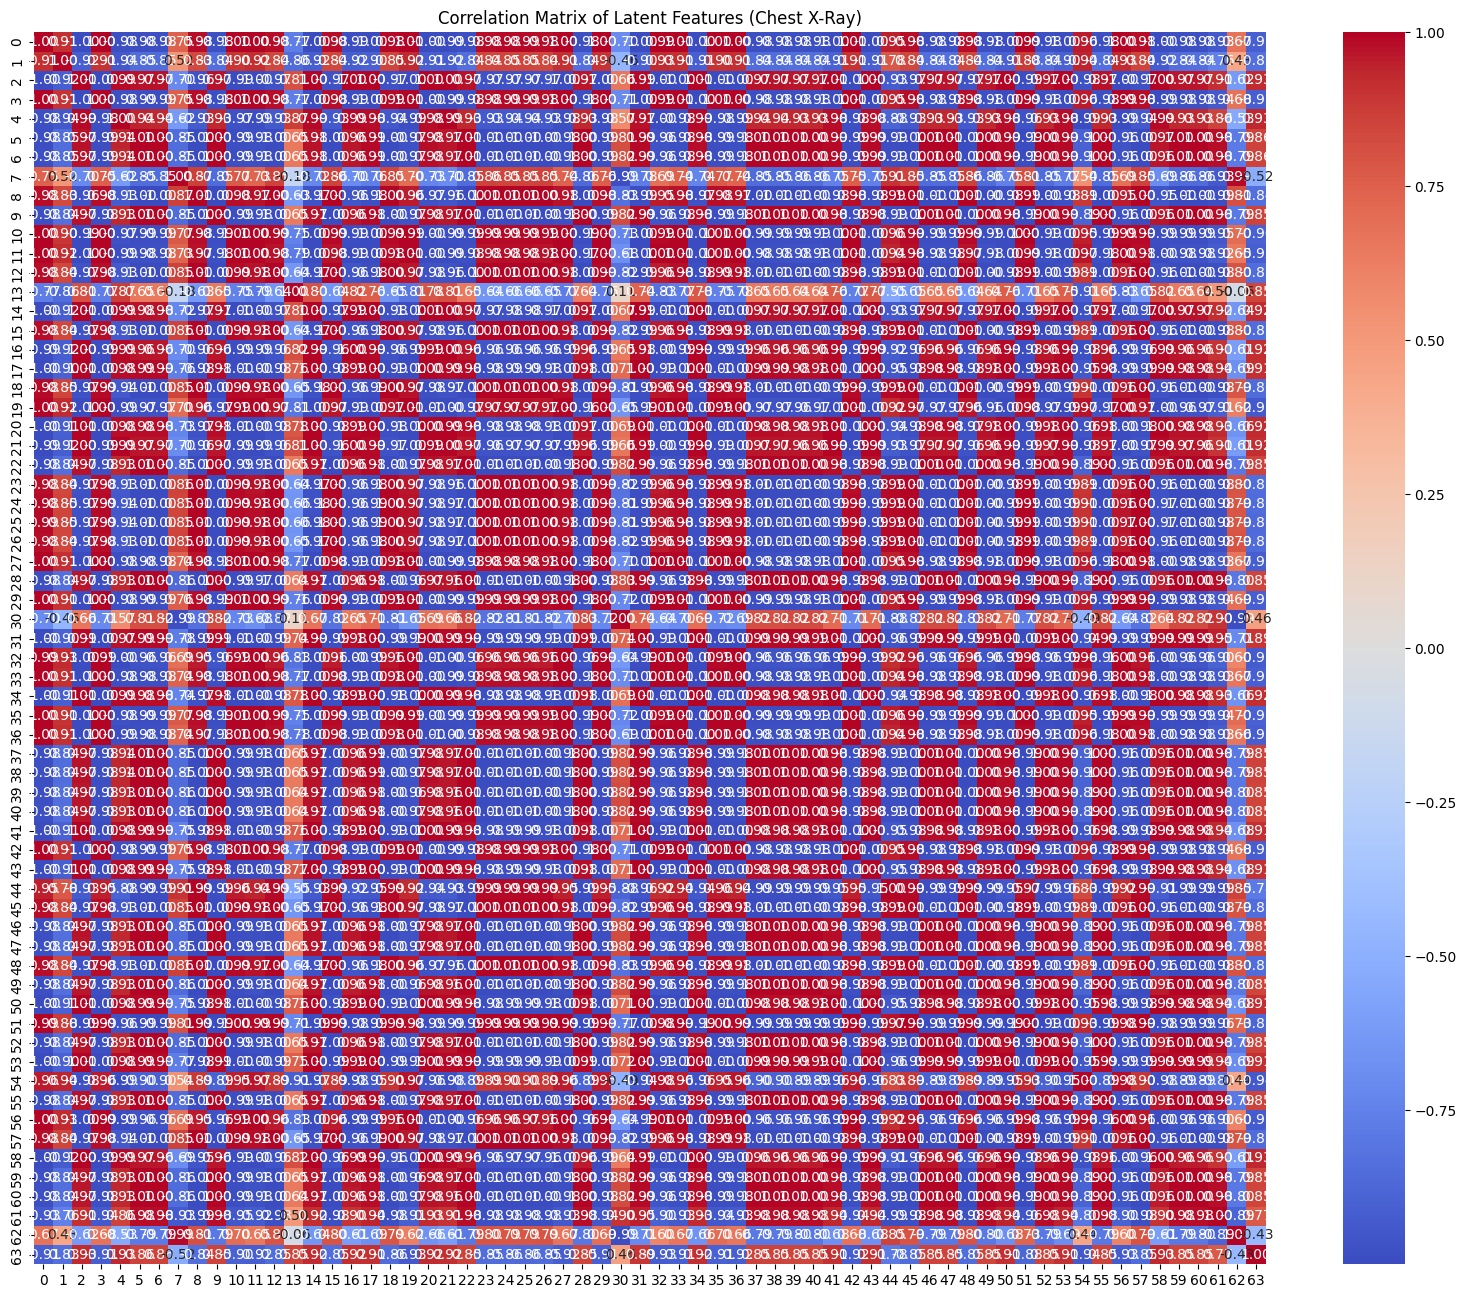

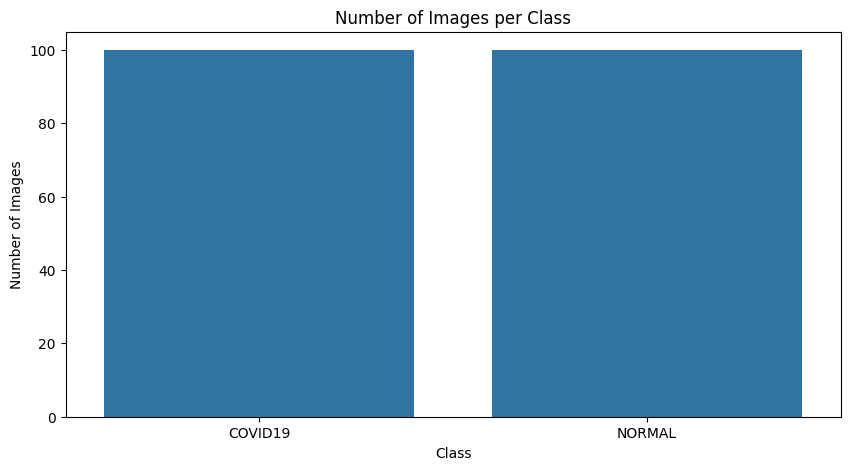

In [26]:
# Bangun autoencoder dengan input shape sesuai dataset grayscale
def build_convolutional_autoencoder(input_shape=(250, 250, 1), latent_dim=64):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 125x125x32
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 63x63x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 32x32x128

    shape_before_flattening = x.shape[1:]
    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)

    x = Dense(np.prod(shape_before_flattening))(latent)
    x = Reshape(target_shape=shape_before_flattening)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 64x64x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 128x128x64
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 256x256x32 (sedikit lebih besar dari 250)

    # Crop to (250, 250, 32)
    from tensorflow.keras.layers import Cropping2D
    x = Cropping2D(cropping=((3, 3), (3, 3)))(x)  # Crop 3 pixels from top/bottom and left/right

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs=input_img, outputs=decoded, name='autoencoder')
    encoder = Model(inputs=input_img, outputs=latent, name='encoder')

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return autoencoder, encoder

autoencoder, encoder = build_convolutional_autoencoder(input_shape=(250, 250, 1), latent_dim=64)

# Latih model (5 epoch untuk contoh cepat)
autoencoder.fit(img_grey, img_grey, epochs=5, batch_size=32)

# Dapatkan latent features
latent_features = encoder.predict(img_grey)

# Hitung korelasi latent features
import pandas as pd
df_latent = pd.DataFrame(latent_features)
corr_matrix = df_latent.corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Latent Features (Chest X-Ray)')
plt.show()

# Visualisasi distribusi dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Splitting Data

Kode di bawah digunakan untuk membagi dataset menjadi data _training_ dan data _testing_.
Fungsi `train_test_split()` dari `sklearn.model_selection` digunakan untuk membagi data fitur (`x`) dan label (`y`) ke dalam dua bagian, yaitu data _training_ dan data _testing_. Parameter `test_size=0.3` berarti 30% dari data akan digunakan sebagai data _testing_, sementara 70% sisanya digunakan untuk _training_. Parameter `random_state=42` digunakan untuk memastikan bahwa pembagian data dilakukan secara acak. Setelah pembagian, variabel `x_train` dan `y_train` menyimpan data _training_ untuk fitur dan label, sedangkan `x_test` dan `y_test` menyimpan data _testing_.
`print(f"Training set size: {len(x_train)}, Test set size: {len(x_test)}")` dan baris berikutnya mencetak jumlah data pada set _training_ dan _testing_.

In [27]:
# 0.3 = 30% data untuk testing (train/test 70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"Training set size: {len(x_train)}, Test set size: {len(x_test)}")
print(f"Training set size: {len(y_train)}, Test set size: {len(y_test)}")


Training set size: 140, Test set size: 60
Training set size: 140, Test set size: 60


## Feature Normalization

Kode di bawah adalah fungsi `normalize_data(data)` yang digunakan untuk normalisasi data menggunakan metode *mean-std* (_z-score normalization_). 
Normalisasi fitur dilakukan agar setiap kolom data memiliki rata-rata (mean) 0 dan standar deviasi (std) 1. Nilai rata-rata (mean) dan standar deviasi (std) untuk setiap fitur (kolom) dihitung menggunakan fungsi `np.mean()` dan `np.std()` dengan `axis=0`. Kemudian, setiap elemen pada data dikurangi dengan rata-ratanya dan dibagi dengan standar deviasinya (`(data - mean) / std`). Hasilnya adalah `normalized_data` yang memiliki skala fitur yang seragam. Setelah fungsi didefinisikan, `x_train` dan `x_test` dinormalisasi.

In [28]:
def min_max_scaling(data):
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

X_train_normalized = min_max_scaling(x_train)
X_test_normalized = min_max_scaling(x_test)

## Modeling

### Define Model

In [29]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode di atas adalah fungsi `generateClassificationReport(y_true, y_pred)` yang digunakan untuk menampilkan hasil evaluasi model klasifikasi. `classification_report()` mencetak metrik evaluasi seperti _precision_, _recall_, _f1-score_, dan _support_ untuk setiap kelas. Lalu, `confusion_matrix()` digunakan untuk menampilkan _confusion matrix_ yang menunjukkan jumlah prediksi benar dan salah untuk masing-masing kelas. `accuracy_score()` menghitung akurasi keseluruhan, yaitu rasio jumlah prediksi yang benar dibandingkan dengan total prediksi.
Setelah fungsi didefinisikan, tiga model klasifikasi dideklarasikan. Pertama, `RandomForestClassifier` digunakan dengan jumlah estimators sebanyak 5 (`n_estimators=5`) dan _seed_ acak (`random_state=42`). Kedua, model `SVC` dari _Support Vector Machine_ digunakan dengan kernel _radial basis function_ (`rbf`), yang cocok untuk data non-linear. Terakhir, `KNeighborsClassifier` digunakan dengan jumlah tetangga (`n_neighbors=5`), yang artinya klasifikasi dilakukan berdasarkan 5 tetangga terdekat.

### Train Random Forest Classifier

Kode ini di bawah ini digunakan untuk _training_ dan _testing_ model klasifikasi **Random Forest**. Pertama, model Random Forest dilatih (_training_) menggunakan data `x_train` dan `y_train` melalui pemanggilan` rf.fit(x_train, y_train)`. Setelah model di-_training_, prediksi dilakukan pada data _training_ dengan `rf.predict(x_train)`, dan hasil prediksi tersebut dibandingkan dengan label aslinya (`y_train`) menggunakan fungsi `generateClassificationReport()` untuk menampilkan metrik evaluasi. Proses yang sama dilakukan untuk data _testing_.

In [30]:
# Train Random Forest Classifier
rf.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(x_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

     COVID19       1.00      0.96      0.98        69
      NORMAL       0.96      1.00      0.98        71

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140

[[66  3]
 [ 0 71]]
Accuracy: 0.9785714285714285

------Testing Set------
              precision    recall  f1-score   support

     COVID19       0.94      0.97      0.95        31
      NORMAL       0.96      0.93      0.95        29

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

[[30  1]
 [ 2 27]]
Accuracy: 0.95


### Train SVM Classifier

Kode ini di bawah ini digunakan untuk _training_ dan _testing_ model klasifikasi **SVM (Support Vector Machine)**. Pertama, model SVM dilatih (_training_) menggunakan data `x_train` dan `y_train` melalui pemanggilan` svm.fit(x_train, y_train)`. Setelah model di-_training_, prediksi dilakukan pada data _training_ dengan `svm.predict(x_train)`, dan hasil prediksi tersebut dibandingkan dengan label aslinya (`y_train`) menggunakan fungsi `generateClassificationReport()` untuk menampilkan metrik evaluasi. Proses yang sama dilakukan untuk data _testing_.

In [31]:
# Train SVM Classifier
svm.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(x_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

     COVID19       0.95      0.80      0.87        69
      NORMAL       0.83      0.96      0.89        71

    accuracy                           0.88       140
   macro avg       0.89      0.88      0.88       140
weighted avg       0.89      0.88      0.88       140

[[55 14]
 [ 3 68]]
Accuracy: 0.8785714285714286

------Testing Set------
              precision    recall  f1-score   support

     COVID19       0.96      0.81      0.88        31
      NORMAL       0.82      0.97      0.89        29

    accuracy                           0.88        60
   macro avg       0.89      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60

[[25  6]
 [ 1 28]]
Accuracy: 0.8833333333333333


### Train KNN Classifier

Kode ini di bawah ini digunakan untuk _training_ dan _testing_ model klasifikasi *KNN (K-Nearest Neighbors)*. Pertama, model KNN dilatih (_training_) menggunakan data `x_train` dan `y_train` melalui pemanggilan` knn.fit(x_train, y_train)`. Setelah model di-_training_, prediksi dilakukan pada data _training_ dengan `knn.predict(x_train)`, dan hasil prediksi tersebut dibandingkan dengan label aslinya (`y_train`) menggunakan fungsi `generateClassificationReport()` untuk menampilkan metrik evaluasi. Proses yang sama dilakukan untuk data _testing_.

In [32]:
# Train KNN Classifier
knn.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(x_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

     COVID19       0.97      0.84      0.90        69
      NORMAL       0.86      0.97      0.91        71

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140

[[58 11]
 [ 2 69]]
Accuracy: 0.9071428571428571

------Testing Set------
              precision    recall  f1-score   support

     COVID19       1.00      0.84      0.91        31
      NORMAL       0.85      1.00      0.92        29

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60

[[26  5]
 [ 0 29]]
Accuracy: 0.9166666666666666


## Evaluasi Ketiga Model Klasifikasi

Kode di bawah ini digunakan untuk membuat dataframe dari hasil _accuracy_, _precision_, _recall_, dan _f1 score_ dari ketiga model klasifikasi.

_Accuracy_ adalah persentase jumlah prediksi benar (positif atau negatif) terhadap keseluruhan hasil prediksi. _Precision_ adalah persentase jumlah prediksi positif benar terhadap jumlah prediksi positif yang dilakukan model (true positif + false positif). _Recall_ adalah persentase jumlah prediksi positif yang benar terhadap jumlah prediksi yang dilakukan (benar ataupun salah). _F1 score_ adalah persentase yang mencerminkan keseimbangan _precision_ dan _recall_.

Berdasarkan hasil percobaan, model terbaik di percobaan ketiga ini adalah model blablabala

## Evaluation With Confusion Matrix

Kode di bawah adalah fungsi `plot_confusion_matrix(y_true, y_pred, title)` yang digunakan untuk menampilkan _confusion matrix_ dari hasil prediksi tiga model klasifikasi yang berbeda, yaitu Random Forest, SVM (Support Vector Machine), dan KNN (K-Nearest Neighbors)._Confusion matrix_ dihitung menggunakan fungsi `confusion_matrix` dari pustaka `sklearn.metrics`. Kemudian, _confusion matrix_ divisualisasikan menggunakan `ConfusionMatrixDisplay`, dan ditampilkan dalam skema warna hijau (`plt.cm.Greens`). Grafik kemudian diberi judul dan ditampilkan menggunakan `plt.show()`.

Selanjutnya, fungsi `plot_confusion_matrix` dipanggil tiga kali, untuk menampilkan _confusion matrix_ dari model Random Forest, SVM, dan KNN. Untuk setiap pemanggilan, hasil prediksi model terhadap data uji (`x_test`) dibandingkan dengan label asli (`y_test`). 

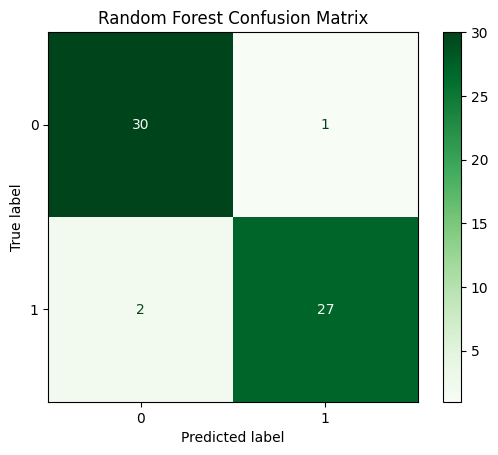

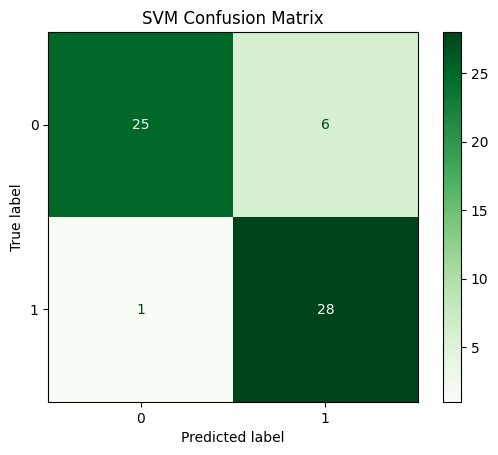

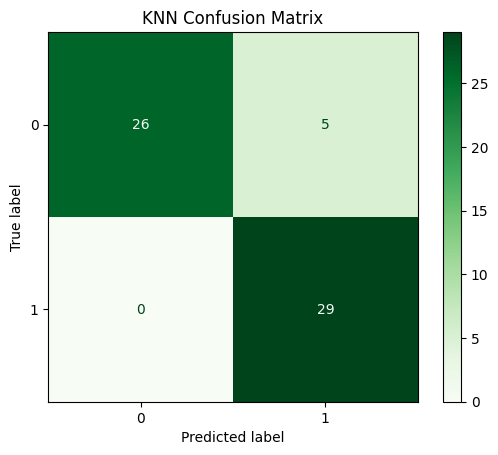

In [33]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(x_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(x_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(x_test), "KNN Confusion Matrix")